# IMPORTS

In [44]:
import yaml
import firebase_admin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import requests
import json

from math import sin, cos, sqrt, atan2, radians


from firebase_admin import credentials
from firebase_admin import firestore

# CONNECT TO FIREBASE

In [2]:
filename='/Users/5danalfaro/OAN/credentials/firebase_parameters.json'

In [3]:
# Use a service account
cred = credentials.Certificate(filename)
firebase_admin.initialize_app(cred)

db = firestore.client()

# GET VILLAGE AND PRIORITY SURVEYS

In [4]:
col_query = db.collection('Surveys').document('Backup').collection('Answers').where(u'survey_type', u'==', u'2-survey_priority')


In [5]:
col_sur_priority = col_query.stream()

In [6]:
l_sur_priority = []
for doc in col_sur_priority:
    l_sur_priority.append(doc.to_dict())

In [7]:
len(l_sur_priority)

85

In [8]:
col_query = (db.collection('Surveys').
                    document('Backup').
                        collection('Answers').
                            where(u'survey_type', u'==', u'1-survey_village')
            )

In [9]:
col_sur_village = col_query.stream()

In [10]:
l_sur_village = []
for doc in col_sur_village:
    l_sur_village.append(doc.to_dict())

In [11]:
len(l_sur_village)

7

In [12]:
[vil['data']['village_name'] for vil in l_sur_village]

['Kora seko Kparou où Sansi Gah Gourou',
 'Tata Lafiarou ou Djonwouro Kparou ',
 'Debbo',
 'Gbérou kpanin',
 'Wodora',
 'Alafiarou',
 'Tata Lafiarou ou Djonwouro Kparou ']

In [13]:
[vil['data']['village_pop'] for vil in l_sur_village]

['null', '80', '120', '150', '70', '400', '80']

# PROCESS DATA

## PRIORISATION DATA

In [14]:
df_priority=pd.DataFrame([{'latitude':doc['coords']['latitude'],
  'longitude':doc['coords']['longitude'],
  'creation_date':doc['creation_date'],
  'nb_basin':doc['data']['nb_basin'],
  'nb_people':doc['data']['nb_people'],
  'nb_diarrhoea':doc['data']['nb_diarrhoea'],
  'nb_malnu':doc['data']['nb_malnu'],
  'water_storage':doc['data']['water_storage'],
  'water_quality':doc['data']['water_quality'],
  'self_manag':doc['data']['self_manag']
  
    } for doc in l_sur_priority
])

## Village data

In [15]:
df_village=pd.DataFrame(
    [{'latitude':doc['coords']['latitude'],
      'longitude':doc['coords']['longitude'],
      'village_coords':doc['data']['village_coords'],
      'creation_date':doc['creation_date'],
      'nb_water_sources':doc['data']['nb_water_sources'],
      'heath_center':doc['data']['heath_center'],
      'village_pop':doc['data']['village_pop'],
      'village_name':doc['data']['village_name'],
      'water_sources':doc['data']['water_sources']

        } for doc in l_sur_village
    ]
)

In [16]:
df_village['longitude']=df_village.apply(lambda x: x['village_coords'].split(' ;')[1],axis=1)

In [17]:
df_village['latitude']=df_village.apply(lambda x: x['village_coords'].split(' ;')[0],axis=1)

In [18]:
l_s_potable= ['PPM','AEV','FPM']

In [19]:
df_village['%_s_potable']=df_village.apply(
    lambda x: 100*(len([source['ws_type'] 
                   for source in x['water_sources'] if source['ws_type'] in l_s_potable])
                /float(x['nb_water_sources']))
    ,axis=1
)

### merge village and priority

In [29]:
'''get village from minimum distance to survey (and date of creation date)'''
def get_village(x):
    min_dist=1
    village=''
    prior_cre_date=x['creation_date']
    lat=float(x['latitude'])
    lon=float(x['longitude'])
    for vil_coords,vil_name in zip(df_village['village_coords'].to_list(),
                                   df_village['village_name'].to_list()
                                  ):
        vil_lat = float(vil_coords.split(' ;')[0])
        vil_lon = float(vil_coords.split(' ;')[1])
        
        distance=((vil_lat-lat)**2+(vil_lon-lon)**2)**0.5
        if min_dist > distance:
            min_dist=distance
            village=vil_name
    #print(prior_cre_date[5:10],
    #      df_village[df_village['village_name']==vil_name]['creation_date'].values[0][5:10],
    #     prior_cre_date[5:10]==df_village[df_village['village_name']==vil_name]['creation_date'].values[0][5:10],
    #     village)
    #        
    return village
        

In [52]:
df_priority['nb_people'] = pd.to_numeric(df_priority['nb_people'],errors='coerce')
df_priority['nb_diarrhoea'] = pd.to_numeric(df_priority['nb_diarrhoea'],errors='coerce')
df_priority['nb_malnu'] = pd.to_numeric(df_priority['nb_malnu'],errors='coerce')
df_priority['nb_basin'] = pd.to_numeric(df_priority['nb_basin'],errors='coerce')
df_priority['water_quality'] = pd.to_numeric(df_priority['water_quality'],errors='coerce')
df_priority['self_manag'] = pd.to_numeric(df_priority['self_manag'],errors='coerce')
df_priority['latitude'] = pd.to_numeric(df_priority['latitude'],errors='coerce')
df_priority['longitude'] = pd.to_numeric(df_priority['longitude'],errors='coerce')

In [22]:
df_priority['l/per']=df_priority['nb_basin']*25/df_priority['nb_people']

In [23]:
df_priority['t_diar']=df_priority['nb_diarrhoea']*100/df_priority['nb_people']

In [24]:
df_priority['t_mal']=df_priority['nb_malnu']*100/df_priority['nb_people']

In [30]:
df_priority['village']=df_priority.apply(lambda x: get_village(x),axis=1)

In [31]:
df_priority

,latitude,longitude,creation_date,nb_basin,nb_people,nb_diarrhoea,nb_malnu,water_storage,water_quality,self_manag,l/per,t_diar,t_mal,village
0,9.9138,3.40457,2019-11-01T08:11:00.456Z,7,4,1,1,NO,4.0,4,43.750000,25.000000,25.000000,Alafiarou
1,9.90037,3.40495,2019-10-30T15:56:30.815Z,8,17,3,0,NO,1.0,4,11.764706,17.647059,0.000000,Alafiarou
2,9.9145,3.40468,2019-11-01T08:18:44.907Z,9,14,3,0,NO,2.0,4,16.071429,21.428571,0.000000,Alafiarou
3,9.90121,3.40528,2019-10-30T16:21:04.159Z,13,10,1,0,NO,2.0,4,32.500000,10.000000,0.000000,Alafiarou
4,9.93477,3.41619,2019-10-29T15:54:25.058Z,6,9,0,0,NO,4.0,5,16.666667,0.000000,0.000000,Kora seko Kparou où Sansi Gah Gourou
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,9.93279,3.41592,2019-10-29T13:36:27.742Z,99,83,3,2,NO,4.0,5,29.819277,3.614458,2.409639,Kora seko Kparou où Sansi Gah Gourou
81,9.86297,3.28377,2019-11-02T12:40:57.354Z,19,15,4,0,NO,2.0,4,31.666667,26.666667,0.000000,Debbo
82,9.8864,3.26168,2019-11-02T10:43:10.355Z,14,12,3,0,NO,2.0,4,29.166667,25.000000,0.000000,Debbo
83,9.87848,3.27046,2019-11-02T11:21:20.038Z,20,10,1,0,NO,2.0,4,50.000000,10.000000,0.000000,Debbo


In [32]:
df_priority.groupby('village').agg({
                                    'nb_people':'sum',
                                    'l/per':'mean',
                                    'nb_diarrhoea':'sum',
                                    'nb_malnu':'sum',
                                    'nb_basin':'sum',
                                    'water_quality':'mean',
                                    'self_manag':'mean',
                                    't_diar':'mean',
                                    't_mal':'mean',
                                    'creation_date':'count'
                            })

,nb_people,l/per,nb_diarrhoea,nb_malnu,nb_basin,water_quality,self_manag,t_diar,t_mal,creation_date
village,,,,,,,,,,
Alafiarou,678,24.630128,138,6,567,1.961538,4.055556,21.758433,1.320547,54
Debbo,227,34.620251,40,3,262,2.066667,4.066667,17.045342,0.702160,15
Kora seko Kparou où Sansi Gah Gourou,194,27.930525,20,2,218,3.666667,4.777778,12.247193,0.267738,9
Tata Lafiarou ou Djonwouro Kparou,77,25.696261,18,1,64,1.857143,4.000000,28.829583,2.380952,7


In [33]:
df_vill_analy=df_priority.groupby('village').agg({
                                    'nb_people':'sum',
                                    'nb_diarrhoea':'sum',
                                    'nb_malnu':'sum',
                                    'nb_basin':'sum',
                                    'water_quality':'mean',
                                    'self_manag':'mean',
                                    'creation_date':'count'
                            }).reset_index()

In [34]:
df_vill_analy['l/per']=df_vill_analy['nb_basin']*25/df_vill_analy['nb_people']

In [35]:
df_vill_analy['t_diar']=df_vill_analy['nb_diarrhoea']*100/df_vill_analy['nb_people']

In [36]:
df_vill_analy['t_mal']=df_vill_analy['nb_malnu']*100/df_vill_analy['nb_people']

In [37]:
col_name=list(df_vill_analy.columns)
col_name[7]='n_enquetes'
df_vill_analy.columns=col_name

In [38]:
df_vill_analy

,village,nb_people,nb_diarrhoea,nb_malnu,nb_basin,water_quality,self_manag,n_enquetes,l/per,t_diar,t_mal
0,Alafiarou,678,138,6,567,1.961538,4.055556,54,20.907080,20.353982,0.884956
1,Debbo,227,40,3,262,2.066667,4.066667,15,28.854626,17.621145,1.321586
2,Kora seko Kparou où Sansi Gah Gourou,194,20,2,218,3.666667,4.777778,9,28.092784,10.309278,1.030928
3,Tata Lafiarou ou Djonwouro Kparou,77,18,1,64,1.857143,4.000000,7,20.779221,23.376623,1.298701


In [137]:
df_village.loc[4,'water_sources']

[{'ws_coords': '9.9056017 ; 3.4013483',
  'ws_coms': 'null',
  'ws_type': 'null',
  'ws_operative': 'YES'},
 {'ws_operative': 'YES',
  'ws_coords': '9.9053433 ; 3.4040567',
  'ws_coms': 'Se gâte souvent ',
  'ws_type': 'PPM'}]

## CONTAR CASAS DESDE OPENSTREETMAPS

In [82]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = ("""
[out:json];
area['name'='"""+str('Alafiarou').upper()+
"""']->.a;
way[building](area.a);
(._;>;);
out body;
""")
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
data = response.json()

In [83]:
houses = []
ways=[elem for elem in data['elements']  if elem['type']=='way']
nodes=[elem for elem in data['elements']  if elem['type']=='node']
for way in ways:
    houses_info={}
    houses_info['id']=way['id']
    nodes_lats=[]
    nodes_longs=[]
    houses_info['nodes']=way['nodes']
    for node in nodes:
        if node['id'] in houses_info['nodes']:
            nodes_lats.append(node['lat'])
            nodes_longs.append(node['lon'])
    houses_info['lat']=np.mean(np.array(nodes_lats))
    houses_info['lon']=np.mean(np.array(nodes_longs))
    houses.append(houses_info)

In [84]:
df_houses=pd.DataFrame(houses)

In [85]:
len(df_houses)

114

In [86]:
def distance(p_1,p_2):
    # approximate radius of earth in m
    R = 6373000

    lat1 = radians(p_1['lat'])
    lon1 = radians(p_1['lon'])
    lat2 = radians(p_2['lat'])
    lon2 = radians(p_2['lon'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [87]:
def has_been_survey(x):
    p_1={'lat':float(x['lat']),'lon':float(x['lon'])}
    points=df_priority.apply(lambda x: True
                             if distance(p_1,{'lat':x['latitude'],'lon':x['longitude']}) <20
                             else False
                                        ,axis=1)
    return points.any()

In [88]:
df_houses['surveyed']=df_houses.apply(lambda x: has_been_survey(x),axis=1)

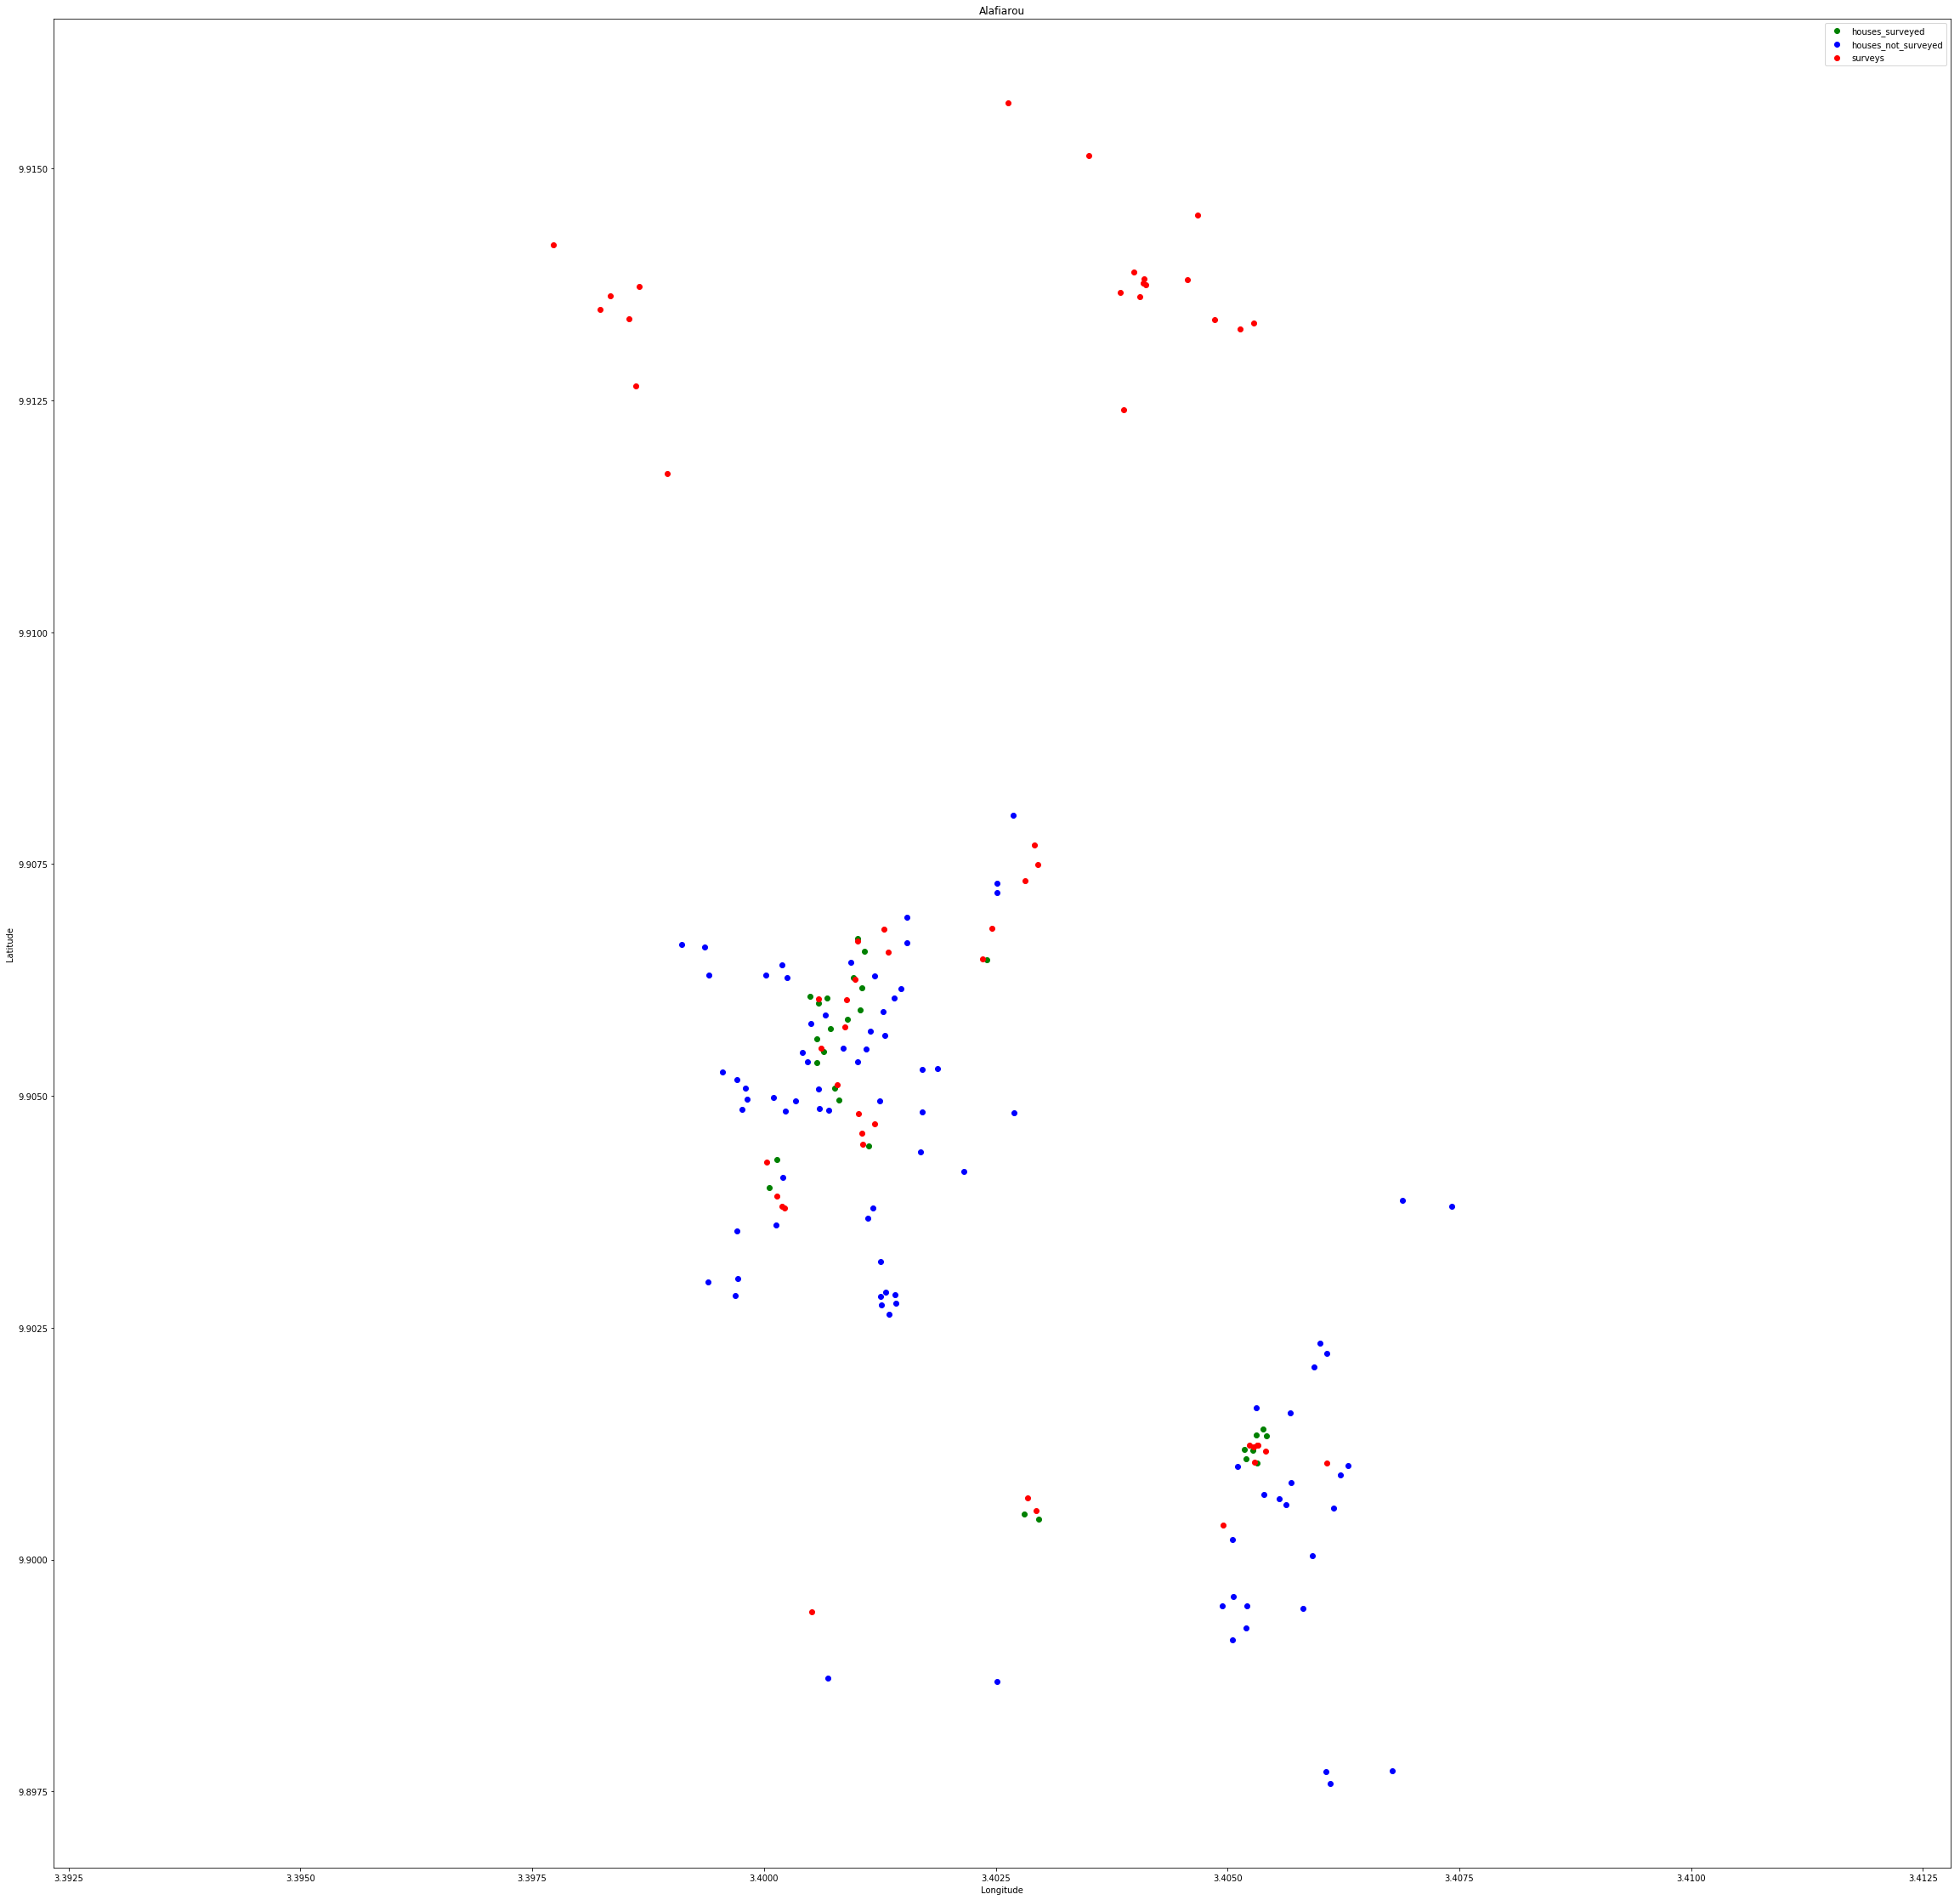

In [95]:
village='Alafiarou'
f,ax = plt.subplots(1,figsize=(40,40))
# Collect coords into list
coords = []

df_survey=df_houses[df_houses['surveyed']]
for a,b in zip(df_survey['lon'].to_list(),df_survey['lat'].to_list()):
        coords.append((a, b))
# Convert coordinates into numpy array
X = np.array(coords)
ax.plot(X[:, 0], X[:, 1], 'o',color='green',label='houses_surveyed')

coords = []
df_notsurvey=df_houses[~df_houses['surveyed']]
for a,b in zip(df_notsurvey['lon'].to_list(),df_notsurvey['lat'].to_list()):
        coords.append((a, b))
# Convert coordinates into numpy array
X = np.array(coords)
ax.plot(X[:, 0], X[:, 1], 'o',color='blue',label='houses_not_surveyed')

coords = []
df_debbo=df_priority[df_priority['village']==village]
for a,b in zip(df_debbo['longitude'].to_list(),df_debbo['latitude'].to_list()):
        coords.append((a, b))
# Convert coordinates into numpy array
X = np.array(coords)
ax.plot(X[:, 0], X[:, 1], 'o',color='red',label='surveys')


plt.title(village)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.legend()
plt.show()

In [104]:
pd.Series([True, True,False]).sum()

2

In [105]:
def n_houses(x):
    p_1={'lat':x['latitude'],'lon':x['longitude']}
    points=df_houses.apply(lambda x: True
                             if distance(p_1,{'lat':x['lat'],'lon':x['lon']}) <20
                             else False
                                        ,axis=1)
    return points.sum()

In [107]:
df_priority['n_houses']=df_priority.apply(lambda x: n_houses(x),axis=1)

In [111]:
df_priority.head(d)

,latitude,longitude,creation_date,nb_basin,nb_people,nb_diarrhoea,nb_malnu,water_storage,water_quality,self_manag,l/per,t_diar,t_mal,village,n_houses
0,9.913798,3.404567,2019-11-01T08:11:00.456Z,7,4,1,1,NO,4.0,4,43.750000,25.000000,25.0,Alafiarou,0
1,9.900368,3.404947,2019-10-30T15:56:30.815Z,8,17,3,0,NO,1.0,4,11.764706,17.647059,0.0,Alafiarou,0
2,9.914502,3.404680,2019-11-01T08:18:44.907Z,9,14,3,0,NO,2.0,4,16.071429,21.428571,0.0,Alafiarou,0
3,9.901213,3.405283,2019-10-30T16:21:04.159Z,13,10,1,0,NO,2.0,4,32.500000,10.000000,0.0,Alafiarou,6
4,9.934765,3.416190,2019-10-29T15:54:25.058Z,6,9,0,0,NO,4.0,5,16.666667,0.000000,0.0,Kora seko Kparou où Sansi Gah Gourou,0


In [113]:
df_priority['n_houses'].sum()

49

In [112]:
df_priority[df_priority['n_houses']!=0]['nb_people'].sum()

280

In [114]:
len(df_houses)

114

In [115]:
280*114/49

651.4285714285714

## DETERMINAR N MUESTRAL

In [116]:
import math
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns

def z_calc(p1, p2, n1, n2):
    p_star = (p1*n1 + p2*n2) / (n1 + n2)
    return (p2 - p1) / math.sqrt(p_star*(1 - p_star)*((1.0 / n1) + (1.0 / n2)))

In [117]:
def sample_required(p1, p_diff, alpha):
    if p_diff <= 0:
        raise ValueError("p_diff must be > 0")
    n = 1
    while True:
        z = z_calc(p1, p1+p_diff, n1=n, n2=n)
        p = 1 - stats.norm.cdf(z)
        if p < alpha:
            break
        n += 1
    return n

In [138]:
p_diffs = [x*.01 for x in range(10,40)]

data = []
for p_diff in p_diffs:
    record = {}
    record['Probability Difference'] = p_diff * 100
    record['Sample Size to Detect Difference'] = sample_required(p1=.5,
                                                                p_diff=p_diff,
                                                                alpha=.05)
    record['Confidence Level'] = '95%'
    record['Initial probability'] = '20%'
    data.append(record)

for p_diff in p_diffs:
    record = {}
    record['Probability Difference'] = p_diff * 100
    record['Sample Size to Detect Difference'] = sample_required(p1=.5,
                                                                p_diff=p_diff,
                                                                alpha=.01)
    record['Confidence Level'] = '99%'
    record['Initial probability'] = '20%'
    data.append(record)

df = pd.DataFrame(data)

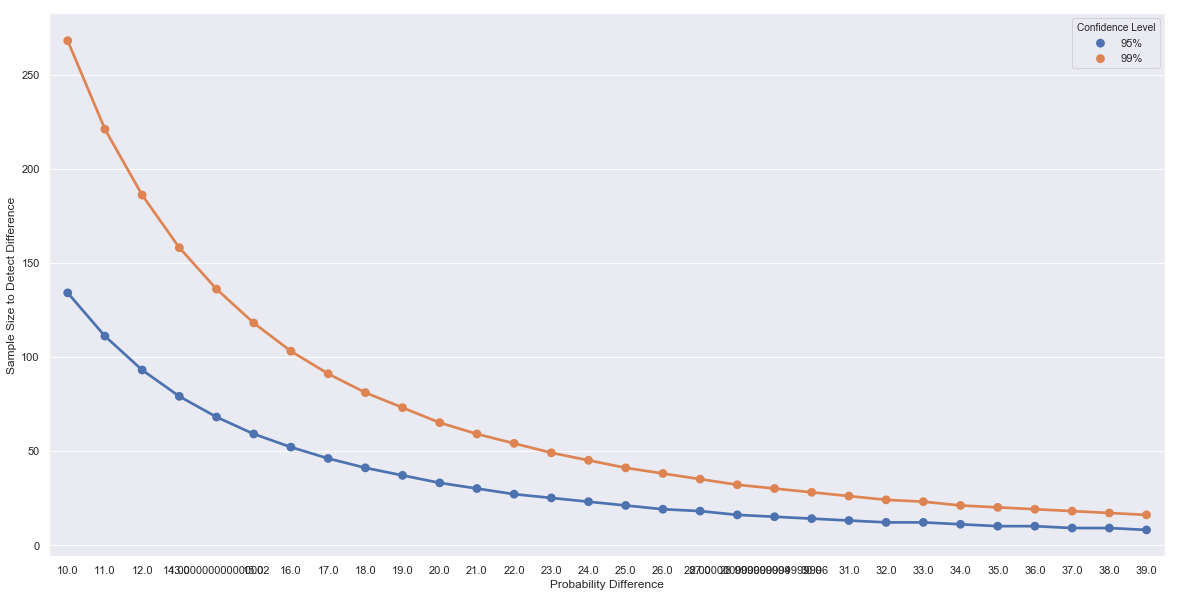

In [142]:
from matplotlib import pyplot
fig, ax = pyplot.subplots(figsize=(20, 10))

sns.set(style='darkgrid')

plot = sns.pointplot(x='Probability Difference',
            y='Sample Size to Detect Difference',
            hue='Confidence Level', ax = ax,
            data=df)